In [1]:
%cd ..

/home/gianscarpe/dev/event-camera


In [2]:
from experimenting.dataset import DHP3DDataset, get_dataloader
from experimenting.dataset.indexes import get_dataset_params
from matplotlib import pyplot as plt
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from importlib import reload  
from omegaconf import DictConfig

%matplotlib inline

In [3]:
def display(img):          
        fig, ax = plt.subplots(ncols=img.shape[0], nrows=1,                              
                               figsize=(20,20))                                                                                   
        for i in range(img.shape[0]):                                                                
            ax[i].imshow(img[i])                                                  
            ax[i].axis('off')
        plt.show()

In [4]:
def plot_2d(dvs_frame, sample_gt, sample_pred):
    " To plot image and 2D ground truth and prediction "
    plt.figure()
    plt.imshow(dvs_frame, cmap='gray')
    plt.plot(sample_gt[:,1], sample_gt[:,0], '.', c='red', label='gt')
    plt.plot(sample_pred[:,1], sample_pred[:,0], '.', c='blue', label='pred')
    plt.legend()

## 

In [5]:
# Augmentation
aug = Compose([CenterCrop(256, 256), ToTensor()])

In [33]:
data_dir = '/data/dhp19/time_count_dataset/movements_per_frame'
labels_dir = '/data/dhp19/time_count_dataset/labels'
test_subjects = [1, 8, 11, 15]
cams = [2]

hparams = DictConfig({'data_dir': data_dir, 'labels_dir' : labels_dir, 'test_subjects':test_subjects, 'cams': cams})
params = get_dataset_params(hparams, save_split=False)

LOADED INDEXES! train: 50828 	 val: 12707 	 test: 24180


In [26]:
d = DHP3DDataset(params['file_paths'], labels_dir, params['test_indexes'], transform=aug)
loader = get_dataloader(d, 32, 2)

In [27]:
batch = next(iter(loader))
x, y = batch

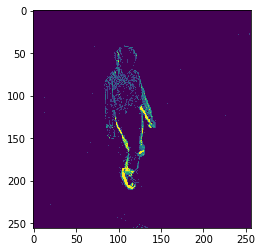

In [28]:
plt.imshow(x[1].squeeze())

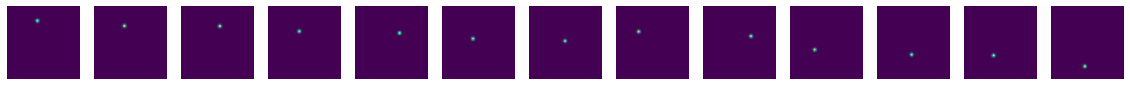

In [16]:
display(y[1].numpy())

## Loaded model for 2d heatmap prediction

In [22]:
import experimenting.models as models
import os
import experimenting.models.metrics as metrics
import experimenting.models.losses as losses
from experimenting.models.dsnt import average_loss
from experimenting.utils import get_joints_from_heatmap

exp_name = 'exp_SGD_0.0001_center_crop_05-17-16-10'
checkpoint_dir = f'/home/gianscarpe/dev/exps/timecount_pose/exps_PoseEstimator/{exp_name}/checkpoints'
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])
model = models.PoseEstimator.load_from_checkpoint(checkpoint_path)
model = model.eval()

In [19]:
loss = losses.PixelWiseLoss('mask_mean')

In [29]:
with torch.no_grad():
    preds = model(x)

/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/nn/functional.py:2875: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [30]:
gt_joints, _ = get_joints_from_heatmap(y)
p_joints, p_conf = get_joints_from_heatmap(preds)

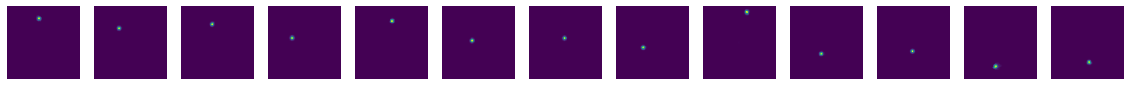

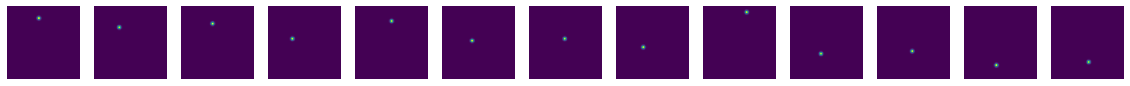

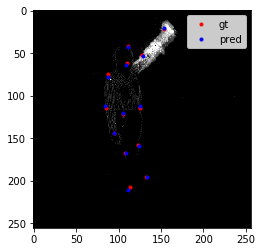

In [31]:
display(preds[2].numpy())
display(y[2].numpy())
plot_2d(x[2].squeeze(), gt_joints[2], p_joints[2])

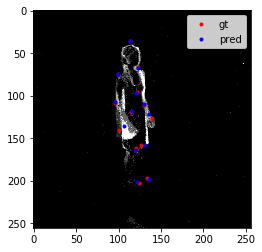

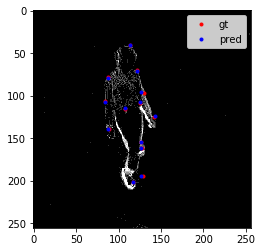

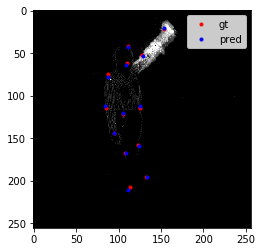

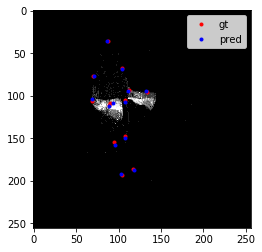

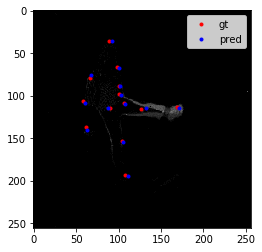

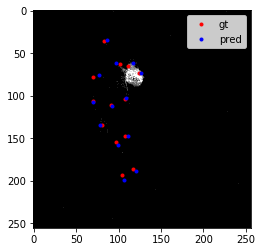

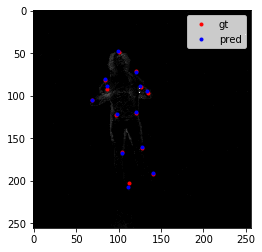

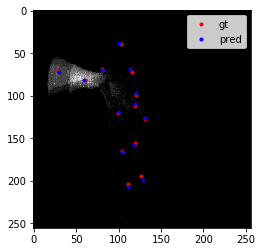

In [32]:
for i in range(0, 8):
    plot_2d(x[i].squeeze(), gt_joints[i], p_joints[i])